In [1]:
%matplotlib inline
import pandas as pd
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt
import numpy as np


kernels = ['linear', 'rbf', 'poly']
def run_svm_with_feature_selection(results, X_encoded, Y, file_name, k_features=10):
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_encoded, Y, test_size=0.2, random_state=42)

    best_model = None
    best_score = -1
    best_kernel = ""
    best_pipeline = None
    best_selector = None
    feature_names = X_encoded.columns

    for kernel in kernels:
        # Build pipeline
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('select', SelectKBest(score_func=f_classif, k=k_features)),
            ('svm', SVC(kernel=kernel, C = 1))
        ])

        # Train
        pipeline.fit(X_train, y_train)

        # Predict
        y_pred = pipeline.predict(X_test)

        # Evaluate
        acc = accuracy_score(y_test, y_pred)
        print(f"Accuracy ({kernel}):", acc)
        cm = confusion_matrix(y_test, y_pred)

        if acc > best_score:
            best_score = acc
            best_model = pipeline.named_steps['svm']
            best_pipeline = pipeline
            best_selector = pipeline.named_steps['select']
            best_kernel = kernel

        results[kernel] = (acc, cm, pipeline)

    if best_pipeline is not None:
        print("Best score found with kernel:", best_kernel)

        # Get selected feature names
        selected_indices = best_selector.get_support(indices=True)
        selected_feature_names = feature_names[selected_indices]

        print(selected_feature_names)


def graph_svm_results(results_arr, file_name_base, results_names = None):
    plt.figure(figsize=(6, 5))

    i = 0
    for r_dict in results_arr:
        x_arr = []
        y_arr = []
        for k, v in r_dict.items():
            x_arr.append(k)
            y_arr.append(v[0])
            
        if results_names:
            plt.plot(x_arr, y_arr, marker='o', linestyle='-', linewidth=2, label=results_names[i])
            i += 1
        else:
            plt.plot(x_arr, y_arr,  marker='o', linestyle='-', linewidth=2)

    plt.title('Accuracy vs K')
    plt.xlabel('K')
    plt.ylabel('Accuracy Score')

    if results_names:
        plt.legend()

    plt.tight_layout()
    plt.savefig(file_name_base, bbox_inches='tight')
    plt.show()

Accuracy (linear): 0.1031
Accuracy (rbf): 0.0962
Accuracy (poly): 0.0975
Best score found with kernel: linear
Index(['Age', 'Year', 'Smoking', 'Treatment_Cost_USD', 'Survival_Years',
       'Cancer_Type_Cervical', 'Cancer_Type_Colon', 'Cancer_Type_Leukemia',
       'Cancer_Type_Prostate', 'Cancer_Type_Skin'],
      dtype='object')


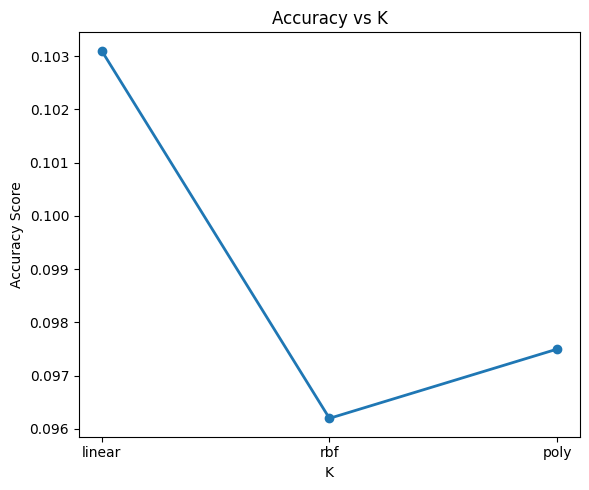

In [2]:
# Experiment 1 - Full Dataset

import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Load CSV
df = pd.read_csv('global_cancer_patients_2015_2024.csv')

# Normalize year
df['Year'] = 2025 - df['Year']

# Encode the combined labels
label_encoder = LabelEncoder()
df['Cancer_Stage_Int'] = label_encoder.fit_transform(df['Cancer_Stage'])

# Save mapping (optional)
label_mapping = dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))

# One-hot encode categorical features
categorical_cols = ['Gender','Cancer_Type']
X = pd.get_dummies(df, columns=categorical_cols)

# Drop original target columns
Y = X['Country_Region']
X = X.drop(['Patient_ID', 'Country_Region', 'Cancer_Stage'], axis=1)  # drop ID and target

# Run the algorithm
full_results = {}
run_svm_with_feature_selection(full_results, X, Y, "cancer_svm_all_features")
graph_svm_results([full_results], "cancer_svm_all_features_permutation")